In [82]:
import json, glob, re, pycm, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, scipy.stats as stats
from IPython.display import display, Markdown

In [83]:
EXPERIMENT_RUN_VERSION = "v15-simpleqa-zero-bil-3-uni-3"
BENCHMARK_SIZE = 1000.
REPEATED_SAMPLES_PER_EVALUATION = 3

In [84]:
def display_cms(cms):
    fig = plt.figure(figsize=(20,14))
    gs = fig.add_gridspec(4, 5, hspace=0.5)
    axes = gs.subplots()
    for ax, (name, cm) in zip(axes.flat, cms):
        df = pd.DataFrame(cm.matrix).T.fillna(0)
        sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
        ax.set_title(name, wrap=True, fontsize=9)
        ax.set(xlabel='Predicted', ylabel='Actual')
    for ax in axes.flat[len(cms):]:
        ax.set_visible(False)
    plt.show()

In [85]:
def unilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "f"]]

In [86]:
def bilateral_truth_value_distribution(df):
    model_evals = df.groupby('model_name')['evaluation'].value_counts().unstack(fill_value=0)
    for stat in ["t","f","n", "b"]:
        if stat not in model_evals:
            model_evals[stat] = 0
    model_evals["t"] = model_evals["t"] / float(BENCHMARK_SIZE)
    model_evals["b"] = model_evals["b"] / float(BENCHMARK_SIZE)
    model_evals["n"] = model_evals["n"] / float(BENCHMARK_SIZE)
    model_evals["f"] = model_evals["f"] / float(BENCHMARK_SIZE)
    return model_evals[["t", "n", "b",  "f"]]

In [87]:
def plot_f1_comparison(df, n, figsize=(15, 6)):
    # Set the colors
    unilateral_color = '#8884d8'
    bilateral_color = '#82ca9d'

    # Create figure with larger size
    plt.figure(figsize=figsize)

    # Calculate bar positions
    x = np.arange(len(df))
    width = 0.35

    # Create bars
    bars1 = plt.bar(x - width/2, df['unilateral F1 macro'], width, label='Unilateral', color=unilateral_color, alpha=0.8)
    bars2 = plt.bar(x + width/2, df['bilateral F1 macro'], width, label='Bilateral', color=bilateral_color, alpha=0.8)

    # Set y-axis limits
    plt.ylim(0, 1.0)

    # Add value labels on top of bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    # Customize the plot
    plt.ylabel('F1 macro (given attempted)', fontsize=12)
    plt.title(f'Unilateral vs Bilateral Evaluation (N={int(n):d}, samples/evaluation={REPEATED_SAMPLES_PER_EVALUATION:d})', fontsize=14, pad=20)
    plt.xticks(x, df['model'], rotation=45, ha='right')

    # Adjust layout to prevent label cutoff
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

In [88]:
def plot_metrics_boxplot(df):
    
    # Create long-format data for the three metrics (ACC, AUC, F1 macro)
    unilateral_data = pd.DataFrame({
        'Metric': ['ACC'] * len(df) + ['AUC'] * len(df) + ['F1 macro'] * len(df),
        'Value': df['unilateral ACC'].tolist() + df['unilateral AUC'].tolist() + df['unilateral F1 macro'].tolist(),
        'Type': ['Unilateral'] * (len(df) * 3)
        })

    bilateral_data = pd.DataFrame({
        'Metric': ['ACC'] * len(df) + ['AUC'] * len(df) + ['F1 macro'] * len(df),
        'Value': df['bilateral ACC'].tolist() + df['bilateral AUC'].tolist() + df['bilateral F1 macro'].tolist(),
        'Type': ['Bilateral'] * (len(df) * 3)
    })

    # Combine the data
    plot_data = pd.concat([unilateral_data, bilateral_data])

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Metric', y='Value', hue='Type', data=plot_data, palette={'Unilateral': '#8884d8', 'Bilateral': '#82ca9d'})
    plt.title('Comparison of Unilateral vs Bilateral Performance Metrics (given attempted)')
    plt.ylabel('Score')
    plt.ylim(0.4, 0.9)

    plt.show()

In [89]:
cms = {}
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
    model = re.match(r'.*/unilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r")))
    cms[model]["unilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
    model = re.match(r'.*/bilateral/(.*)-simpleqa.json', file).group(1)
    if model not in cms:
        cms[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r")))
    cms[model]["bilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])

In [90]:
stats_df = pd.DataFrame([ 
    {
        'model': model,
        'unilateral N': cms[model]["unilateral"].POP['t'], 
        'unilateral ACC': cms[model]["unilateral"].ACC_Macro, 
        'unilateral AUC': cms[model]["unilateral"].AUC['t'], 
        'unilateral F1 macro': cms[model]["unilateral"].F1_Macro,
        'bilateral N': cms[model]["bilateral"].POP['t'], 
        'bilateral ACC': cms[model]["bilateral"].ACC_Macro, 
        'bilateral AUC': cms[model]["bilateral"].AUC['t'], 
        'bilateral F1 macro': cms[model]["bilateral"].F1_Macro,
    } 
    for model in cms if "bilateral" in cms[model]
])
stats_df['delta F1'] = stats_df['bilateral F1 macro'] - stats_df['unilateral F1 macro']
stats_df['unilateral coverage'] = stats_df['unilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df['bilateral coverage'] = stats_df['bilateral N'].apply(lambda x: x / BENCHMARK_SIZE)
stats_df = stats_df[[ 'model', 
                     'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro', 
                     'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro', 
                     'delta F1' ]].sort_values('delta F1', ascending=False)

In [91]:
columns = [
    ('', 'model'),
    ('unilateral', 'coverage'),
    ('unilateral', 'ACC'),
    ('unilateral', 'AUC'),
    ('unilateral', 'F1 macro'),
    ('bilateral', 'coverage'),
    ('bilateral', 'ACC'),
    ('bilateral', 'AUC'),
    ('bilateral', 'F1 macro'),
    ('', 'delta F1')
]

original_columns = ['model',
                   'unilateral coverage', 'unilateral ACC', 'unilateral AUC', 'unilateral F1 macro',
                   'bilateral coverage', 'bilateral ACC', 'bilateral AUC', 'bilateral F1 macro',
                   'delta F1']

df_new = stats_df[original_columns].copy()
df_new.columns = pd.MultiIndex.from_tuples(columns)
df_new = df_new.reset_index(drop=True)

df_new = df_new.style.format({
    ('', 'model'): '{}',
    ('unilateral', 'coverage'): '{:.3f}',
    ('unilateral', 'ACC'): '{:.3f}',
    ('unilateral', 'AUC'): '{:.3f}',
    ('unilateral', 'F1 macro'): '{:.3f}',
    ('bilateral', 'coverage'): '{:.3f}',
    ('bilateral', 'ACC'): '{:.3f}',
    ('bilateral', 'AUC'): '{:.3f}',
    ('bilateral', 'F1 macro'): '{:.3f}',
    ('', 'delta F1'): '{:.3f}'
})

In [92]:
# For ACC
uni_acc = stats_df['unilateral ACC']
bi_acc = stats_df['bilateral ACC']
stat_acc, p_acc = stats.mannwhitneyu(uni_acc, bi_acc, alternative='less')

# For AUC
uni_auc = stats_df['unilateral AUC']
bi_auc = stats_df['bilateral AUC']
stat_auc, p_auc = stats.mannwhitneyu(uni_auc, bi_auc, alternative='less')

# For F1 macro
uni_f1 = stats_df['unilateral F1 macro']
bi_f1 = stats_df['bilateral F1 macro']
stat_f1, p_f1 = stats.mannwhitneyu(uni_f1, bi_f1, alternative='less')

In [93]:
unilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
   unilateral_results += json.load(open(file, "r"))
df_unilateral = pd.DataFrame(unilateral_results)
df_unilateral_tv_dist = unilateral_truth_value_distribution(df_unilateral)

In [94]:
bilateral_results = []
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
   bilateral_results += json.load(open(file, "r"))
df_bilateral = pd.DataFrame(bilateral_results)
df_bilateral_tv_dist = bilateral_truth_value_distribution(df_bilateral)

# Performance by model

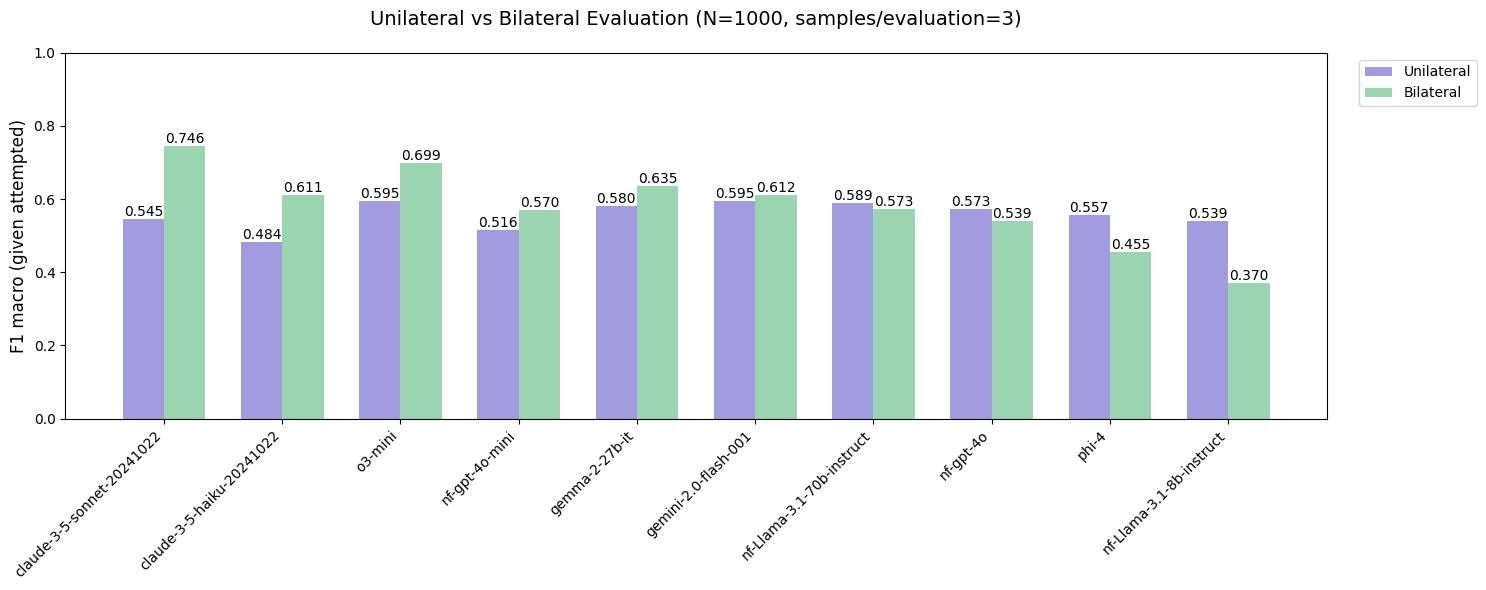

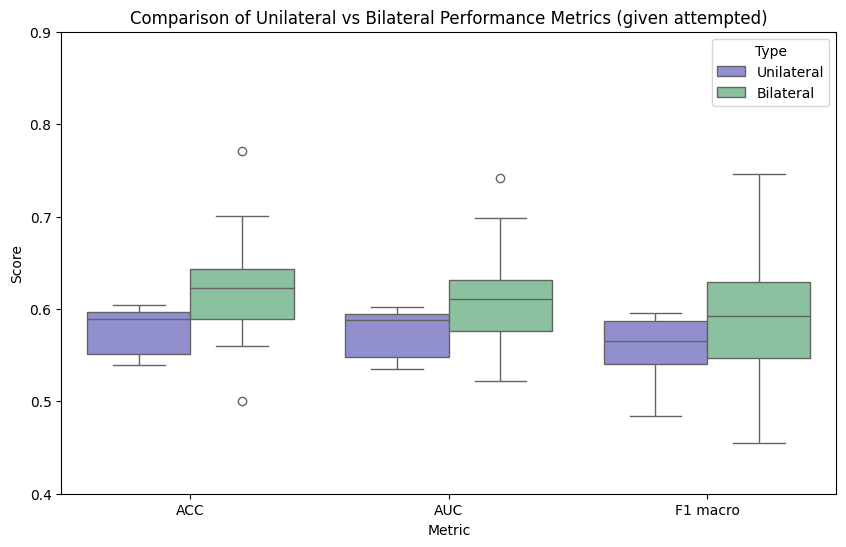

## Mann-Whitney U test

* ACC: U=23.0, p=0.023

* AUC: U=30.0, p=0.070

* F1 macro: U=38.0, p=0.192

# Truth value distribution by model

## Unilateral

evaluation,t,n,f
model_name,,,
claude-3-5-haiku-20241022,0.180,0.000,0.820
claude-3-5-sonnet-20241022,0.168,0.000,0.832
google/gemini-2.0-flash-001,0.519,0.014,0.467
google/gemma-2-27b-it,0.359,0.004,0.637
microsoft/phi-4,0.311,0.000,0.689
nf-Llama-3.1-70b-instruct,0.505,0.038,0.457
nf-Llama-3.1-8b-instruct,0.220,0.510,0.270
nf-gpt-4o,0.237,0.000,0.763
nf-gpt-4o-mini,0.265,0.000,0.735


## Bilateral

evaluation,t,n,b,f
model_name,,,,
claude-3-5-haiku-20241022,0.160,0.742,0.028,0.070
claude-3-5-sonnet-20241022,0.114,0.503,0.052,0.331
google/gemini-2.0-flash-001,0.208,0.279,0.273,0.240
google/gemma-2-27b-it,0.093,0.810,0.022,0.075
microsoft/phi-4,0.057,0.230,0.114,0.599
nf-Llama-3.1-70b-instruct,0.184,0.771,0.015,0.030
nf-Llama-3.1-8b-instruct,0.043,0.956,0.000,0.001
nf-gpt-4o,0.076,0.473,0.017,0.434
nf-gpt-4o-mini,0.113,0.671,0.019,0.197


# Confusion matrices given attempted by model

## claude-3-5-sonnet-20241022

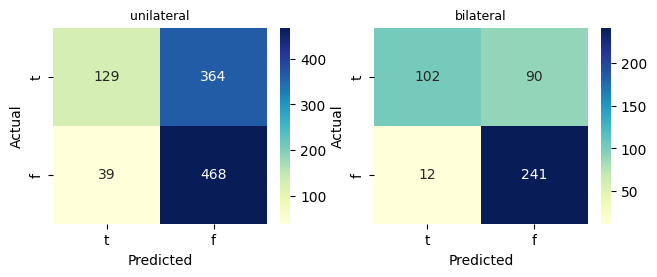

## nf-Llama-3.1-70b-instruct

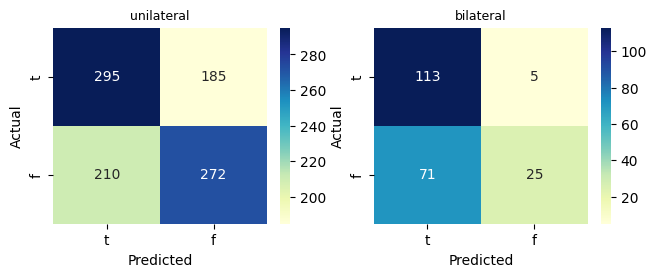

## claude-3-5-haiku-20241022

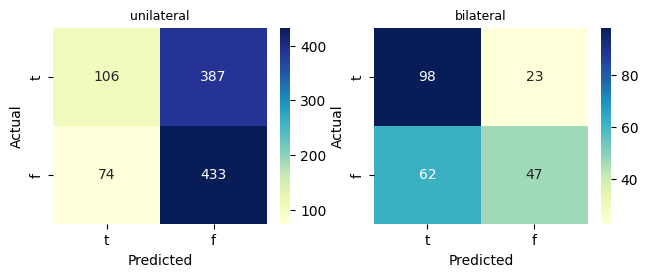

## gemini-2.0-flash-001

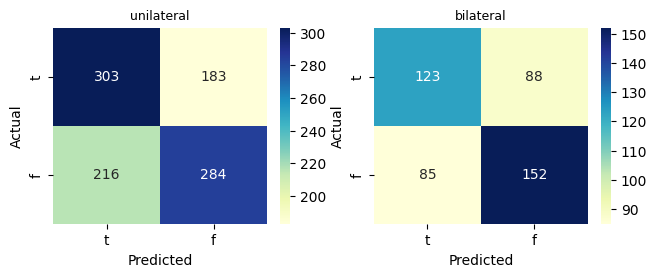

## nf-gpt-4o-mini

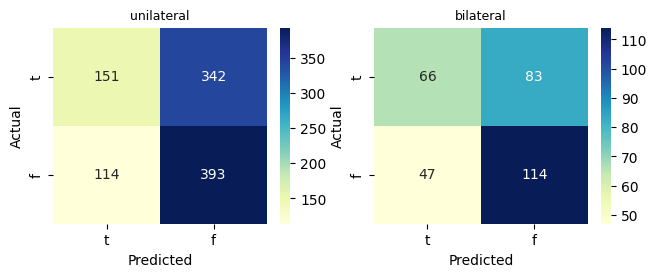

## nf-Llama-3.1-8b-instruct

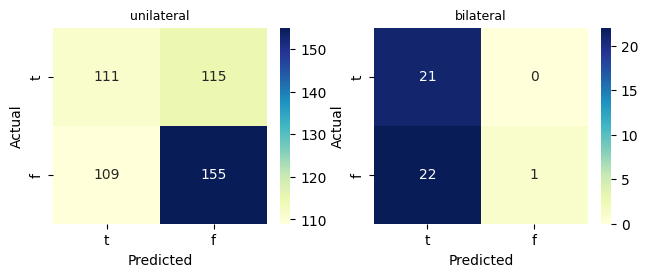

## gemma-2-27b-it

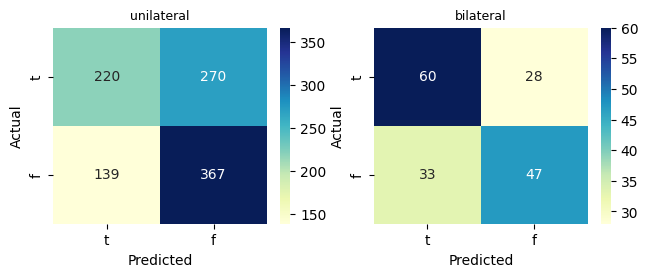

## o3-mini

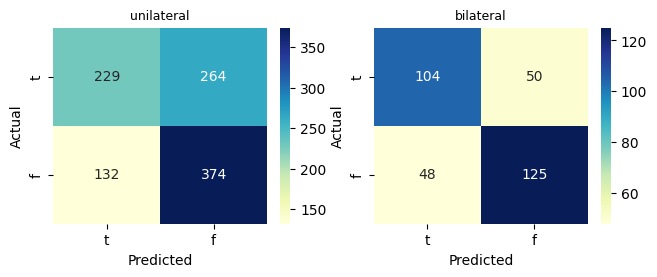

## phi-4

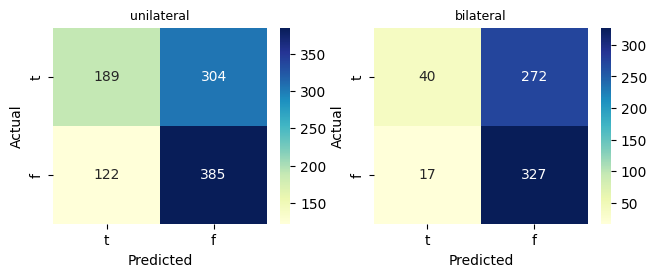

## nf-gpt-4o

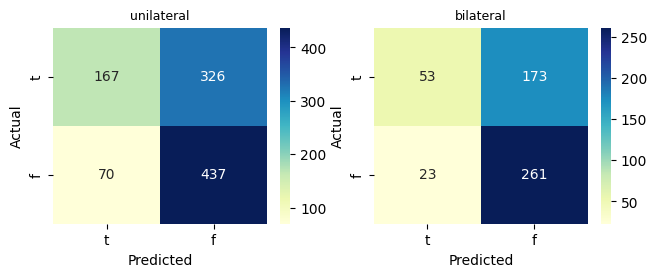

In [95]:
display(Markdown("# Performance by model"))
display(df_new)
plot_f1_comparison(stats_df, BENCHMARK_SIZE)
plot_metrics_boxplot(stats_df)
display(Markdown("## Mann-Whitney U test"))
display(Markdown(f"* ACC: U={stat_acc:.1f}, p={p_acc:.3f}"))
display(Markdown(f"* AUC: U={stat_auc:.1f}, p={p_auc:.3f}"))
display(Markdown(f"* F1 macro: U={stat_f1:.1f}, p={p_f1:.3f}"))
display(Markdown("# Truth value distribution by model"))
display(Markdown(f'## Unilateral'))
display(df_unilateral_tv_dist)
display(Markdown(f'## Bilateral'))
display(df_bilateral_tv_dist)
display(Markdown("# Confusion matrices given attempted by model"))
for model in cms:
    if "bilateral" in cms[model]:
        display(Markdown(f'## {model}'))
        display_cms([(f"unilateral", cms[model]["unilateral"]), (f"bilateral", cms[model]["bilateral"])])